<a href="https://colab.research.google.com/github/navinor/dl-survey-live-lab-2025/blob/main/notebooks/01_baseline_support_vector_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 — Baseline Random Forest (Student)

**Today we will:**
1) Load the Adult dataset (classification: `income`).
2) Split train/test **first** (avoid leakage).
3) Handle missing values (numeric: mean; categorical: most frequent).
4) Encode categorical features:
   - Label encode **one** column (`sex`)
   - One-hot encode the rest
5) (Practice) Scale numeric features (StandardScaler).
6) Train a **RandomForestClassifier** and evaluate it.
7) **Deep dive** into the RF object: attributes & methods.
8) Try a few hyperparameters and record results in your `students/experiment_log.md`.
9) Peek at **GridSearchCV** (teacher-led demo).

> As you work: add short notes in your experiment log (Goal → Setup → Results → Reflection).


### Setup

In [26]:
# 0) Setup
!pip -q install scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.utils import resample # downsample the dataset
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
print("Ready.")


Ready.


### Load data

In [32]:
# 1) Load the Adult dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame.copy()
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


**Question:** Is this a classification or regression problem?  
**Target column:** ???


### Choose columns & split FIRST

In [33]:
# 2) Choose columns (keep it small for speed)
numeric_features = ["age", "hours-per-week", "education-num", "capital-gain", "capital-loss"]
categorical_features = ["workclass", "marital-status", "occupation", "sex", "native-country"]
target_col = "class"

use_cols = numeric_features + categorical_features + [target_col]
df = df[use_cols].copy()



In [10]:
df_downsampled = resample(df, replace=False, n_samples=5000, random_state=42)

In [35]:
# 3) Split FIRST (to avoid leakage)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((39073, 10), (9769, 10))

In [85]:
# reset indices
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# select ballers/nonballers
X_train_ballers = X_train_reset[y_train.reset_index(drop=True) == ">50K"]
y_train_ballers = y_train_reset[y_train.reset_index(drop=True) == ">50K"]

X_train_nonballers = X_train_reset[y_train.reset_index(drop=True) == "<=50K"] # select nonballers
y_train_nonballers = y_train_reset[y_train.reset_index(drop=True) == "<=50K"]

# concat X_train and y_train ballers and nonballers together
train_ballers = pd.concat([X_train_ballers, y_train_ballers], axis=1)
train_ballers_downsampled = resample(train_ballers, replace=False, n_samples=1000, random_state=42)

train_nonballers = pd.concat([X_train_nonballers, y_train_nonballers], axis=1)
train_nonballers_downsampled = resample(train_nonballers, replace=False, n_samples=1000, random_state=42)

# downsample ballers and nonballers
X_train_ballers_downsampled = train_ballers_downsampled.drop(columns=[target_col])
y_train_ballers_downsampled = train_ballers_downsampled[target_col]

X_train_nonballers_downsampled = train_nonballers_downsampled.drop(columns=[target_col])
y_train_nonballers_downsampled = train_nonballers_downsampled[target_col]


# Concatenate downsampled training data
X_train_downsampled = pd.concat([X_train_ballers_downsampled, X_train_nonballers_downsampled])
y_train_downsampled = pd.concat([y_train_ballers_downsampled, y_train_nonballers_downsampled])

# Display the shapes of the downsampled training data
print("Shape of downsampled X_train:", X_train_downsampled.shape)
print("Shape of downsampled y_train:", y_train_downsampled.shape)

display(X_train_downsampled.head())
display(y_train_downsampled.head())

Shape of downsampled X_train: (2000, 10)
Shape of downsampled y_train: (2000,)


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
521,45,40,9,0,0,Federal-gov,Married-civ-spouse,Craft-repair,Male,United-States
737,54,40,10,0,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States
740,48,55,13,0,0,NaN,Married-civ-spouse,NaN,Male,United-States
660,50,40,16,0,0,Self-emp-inc,Separated,Prof-specialty,Male,United-States
411,29,40,14,0,1977,Private,Married-civ-spouse,Prof-specialty,Male,United-States


,class
521,>50K
737,>50K
740,>50K
660,>50K
411,>50K


In [98]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

X_test_ballers = X_test_reset[y_test_reset == ">50K"]
y_test_ballers = y_test_reset[y_test_reset == ">50K"]

X_test_nonballers = X_test_reset[y_test_reset == "<=50K"]
y_test_nonballers = y_test_reset[y_test_reset == "<=50K"]

test_ballers = pd.concat([X_test_ballers, y_test_ballers], axis=1)
test_ballers_downsampled = resample(test_ballers, replace=False, n_samples=1000, random_state=42)

test_nonballers = pd.concat([X_test_nonballers, y_test_nonballers], axis=1)
test_nonballers_downsampled = resample(test_nonballers, replace=False, n_samples=1000, random_state=42)


X_test_ballers_downsampled = test_ballers_downsampled.drop(columns=[target_col])
y_test_ballers_downsampled = test_ballers_downsampled[target_col]

X_test_nonballers_downsampled = test_nonballers_downsampled.drop(columns=[target_col])
y_test_nonballers_downsampled = test_nonballers_downsampled[target_col]


# Concatenate downsampled test data
X_test_downsampled = pd.concat([X_test_ballers_downsampled, X_test_nonballers_downsampled])
y_test_downsampled = pd.concat([y_test_ballers_downsampled, y_test_nonballers_downsampled])

# Display the shapes of the downsampled test data
print("\nShape of downsampled X_test:", X_test_downsampled.shape)
print("Shape of downsampled y_test:", y_test_downsampled.shape)

display(X_test_downsampled.head())
display(y_test_downsampled.head())


Shape of downsampled X_test: (2000, 10)
Shape of downsampled y_test: (2000,)


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
521,62,60,14,0,0,State-gov,Married-civ-spouse,Prof-specialty,Male,United-States
737,36,36,13,7298,0,Private,Married-civ-spouse,Other-service,Male,United-States
740,42,40,9,7298,0,Private,Married-civ-spouse,Machine-op-inspct,Female,United-States
660,35,32,13,0,0,Private,Widowed,Prof-specialty,Female,United-States
411,39,40,13,0,0,Private,Married-civ-spouse,Sales,Male,Canada


,class
521,>50K
737,>50K
740,>50K
660,>50K
411,>50K


In [86]:
display(X_train_ballers_downsampled.head())
display(y_train_ballers_downsampled.head())

display(X_train_nonballers_downsampled.head())
display(y_train_nonballers_downsampled.head())

,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
521,45,40,9,0,0,Federal-gov,Married-civ-spouse,Craft-repair,Male,United-States
737,54,40,10,0,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States
740,48,55,13,0,0,NaN,Married-civ-spouse,NaN,Male,United-States
660,50,40,16,0,0,Self-emp-inc,Separated,Prof-specialty,Male,United-States
411,29,40,14,0,1977,Private,Married-civ-spouse,Prof-specialty,Male,United-States


,class
521,>50K
737,>50K
740,>50K
660,>50K
411,>50K


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
1521,23,40,10,0,0,Private,Never-married,Transport-moving,Male,United-States
1737,24,30,10,0,0,Private,Never-married,Handlers-cleaners,Female,United-States
1740,26,45,9,0,0,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Male,United-States
1660,28,42,9,0,0,Private,Never-married,Handlers-cleaners,Male,United-States
1411,42,30,9,0,0,Private,Married-civ-spouse,Transport-moving,Male,United-States


,class
1521,<=50K
1737,<=50K
1740,<=50K
1660,<=50K
1411,<=50K


**Why split first?**  
So that ....


In [89]:
X_train = X_train_downsampled
y_train = y_train_downsampled

X_test = X_test_downsampled
y_test = y_test_downsampled

### Handle missing values

In [90]:
# 4) Impute missing values
# Numeric → mean (try median later if you like)
num_imputer = SimpleImputer(strategy="mean")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_features]),
                           columns=numeric_features, index=X_train.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[numeric_features]),
                           columns=numeric_features, index=X_test.index)

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_raw = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]),
                               columns=categorical_features, index=X_train.index)
X_test_cat_raw  = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]),
                               columns=categorical_features, index=X_test.index)


### Encode categoricals

In [91]:
# 5) Encode categoricals
# Label-encode ONE column ('sex'); one-hot the rest
label_encode_col = "sex"

# Copies
X_train_processed = X_train_cat_raw.copy()
X_test_processed  = X_test_cat_raw.copy()

# LabelEncoder: fit on train, apply to test
le = LabelEncoder()
X_train_processed[label_encode_col] = le.fit_transform(X_train_processed[label_encode_col])
X_test_processed[label_encode_col]  = le.transform(X_test_processed[label_encode_col])

# One-hot all other categorical columns
onehot_cols = [c for c in X_train_processed.columns if c != label_encode_col]

# Version-safe: sparse_output (>=1.2) vs sparse (<1.2)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train_ohe_array = ohe.fit_transform(X_train_processed[onehot_cols])
X_test_ohe_array  = ohe.transform(X_test_processed[onehot_cols])

ohe_feature_names = ohe.get_feature_names_out(onehot_cols)
X_train_ohe = pd.DataFrame(X_train_ohe_array, columns=ohe_feature_names)
X_test_ohe  = pd.DataFrame(X_test_ohe_array,  columns=ohe_feature_names)

# Combine label-encoded + one-hot (reset indices for alignment)
label_encoded_train = X_train_processed[[label_encode_col]].reset_index(drop=True)
label_encoded_test  = X_test_processed[[label_encode_col]].reset_index(drop=True)
X_train_cat = pd.concat([label_encoded_train, X_train_ohe.reset_index(drop=True)], axis=1)
X_test_cat  = pd.concat([label_encoded_test,  X_test_ohe.reset_index(drop=True)],  axis=1)

X_train_cat.shape, X_test_cat.shape


((2000, 62), (2000, 62))

In [92]:
y_test

,class
2687,>50K
5936,>50K
1610,>50K
9632,>50K
1081,>50K
...,...
8336,<=50K
4369,<=50K
4048,<=50K
5419,<=50K


**Reflect:**  
- When might **label encoding** be risky?  
- Why is **one-hot** often safer for models like Logistic Regression or Neural Nets?


### Scale numeric features (practice)

In [93]:
# 6) Scale numeric features (practice—even if RF doesn’t need it)
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numeric_features)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num),   columns=numeric_features)

# Assemble final matrices (reset indices to align rows)
X_train_final = pd.concat([X_train_num_scaled.reset_index(drop=True),
                           X_train_cat.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_num_scaled.reset_index(drop=True),
                           X_test_cat.reset_index(drop=True)],  axis=1)

X_train_final.shape, X_test_final.shape


((2000, 67), (2000, 67))

**When would you prefer**:
- `MinMaxScaler` ?
- `RobustScaler` ?


# Support Vector Machine

In [102]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_final, y_train)

SVC(random_state=42)

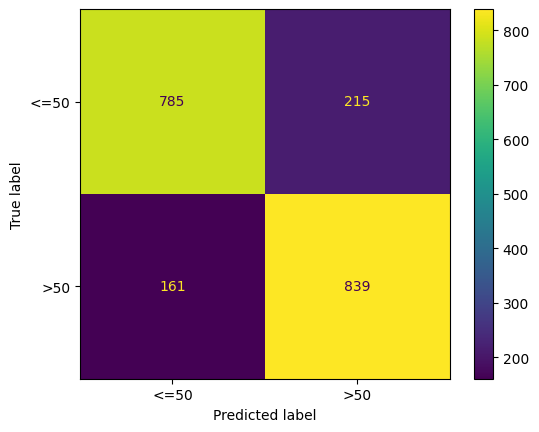

In [103]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                      X_test_final,
                                      y_test,
                                      values_format='d',
                                      display_labels=["<=50", ">50"])

In [ ]:
param_grid = [
  {
      'C': [0.1, 1, 10], # controls hard/soft margin
      'kernel': ['rbf', 'poly', 'sigmoid'], # chooses kernel
      'gamma': ['scale', 'auto', 0.1, 1], # influence of a single training point.
      'degree': [2, 3, 4], # used in poly kernel
      'coef0': [0.0, 0.1, 0.5], # used in poly and sigmoid
  },
]

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1
    )

optimal_params.fit(X_train_final, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


In [104]:
clf_svm = SVC(random_state=42, C=1, gamma='scale')
clf_svm.fit(X_train_final, y_train)

SVC(C=1, random_state=42)

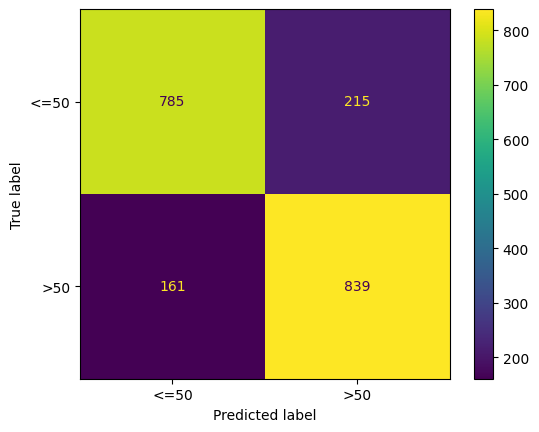

In [105]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                      X_test_final,
                                      y_test,
                                      values_format='d',
                                      display_labels=["<=50", ">50"])

### Saving Model Objects to a Pickle File

In [21]:
from google.colab import drive
drive.mount('/content/drive') # Mount your drive

Mounted at /content/drive


In [22]:
#change directory to where you want the model to be saved in your drive
%cd /content/drive/MyDrive/ADS2_Aaron/data

/content/drive/MyDrive/ADS2_Aaron/data


In [25]:
import pickle

print("SAVING COMPLETE MODEL PACKAGE")
print("=" * 50)

# Create a complete model package
model_package = {
    'model': clf_svm,
    'preprocessors': {
        'num_imputer': num_imputer,
        'scaler': scaler,
        'cat_imputer': cat_imputer,
        'label_encoder': le,
        'onehot_encoder': ohe
    },
    'data': {
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train,
        'y_test': y_test
    }
}


with open('01_baseline_svm_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Saved: 01_baseline_svm_model.pkl")

SAVING COMPLETE MODEL PACKAGE
Saved: 01_baseline_svm_model.pkl
